In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7488 - acc: 0.4663
Epoch 00001: val_loss improved from inf to 3.92718, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_4_conv_checkpoint/001-3.9272.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 3.7488 - acc: 0.4662 - val_loss: 3.9272 - val_acc: 0.4426
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0549 - acc: 0.7171
Epoch 00002: val_loss improved from 3.92718 to 3.82459, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_4_conv_checkpoint/002-3.8246.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 2.0548 - acc: 0.7171 - val_loss: 3.8246 - val_acc: 0.5236
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4185 - acc: 0.8063
Epoch 00003: val_loss improved from 3

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4454 - acc: 0.9598
Epoch 00028: val_loss did not improve from 3.33018
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.4455 - acc: 0.9598 - val_loss: 4.4221 - val_acc: 0.6469
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3980 - acc: 0.9644
Epoch 00029: val_loss did not improve from 3.33018
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.3981 - acc: 0.9644 - val_loss: 4.4121 - val_acc: 0.6434
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3959 - acc: 0.9654
Epoch 00030: val_loss did not improve from 3.33018
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.3960 - acc: 0.9653 - val_loss: 3.7500 - val_acc: 0.6956
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4160 - acc: 0.9635
Epoch 00031: val_loss did not improve from 3.33018
36805/36805 [========

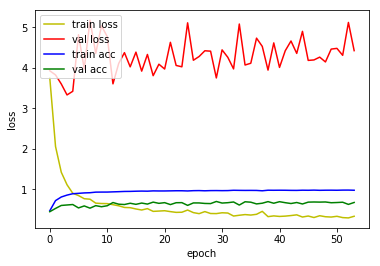

4815/4815 [==============================] - 5s 1ms/sample - loss: 3.6625 - acc: 0.5782
Loss: 3.6625097466901577 Accuracy: 0.5781931

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0698 - acc: 0.5181
Epoch 00001: val_loss improved from inf to 1.84966, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_5_conv_checkpoint/001-1.8497.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 2.0697 - acc: 0.5181 - val_loss: 1.8497 - val_acc: 0.5118
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0837 - acc: 0.7322
Epoch 00002: val_loss improved from 1.84966 to 1.72805, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_5_conv_checkpoint/002-1.7281.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.0838 - acc: 0.7322 - val_loss: 1.7281 - val_acc: 0.6254
Epoch 3/500
36800/36805 [======================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0772 - acc: 0.9848
Epoch 00029: val_loss did not improve from 1.42978
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0772 - acc: 0.9848 - val_loss: 2.4425 - val_acc: 0.7174
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9825
Epoch 00030: val_loss did not improve from 1.42978
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0991 - acc: 0.9825 - val_loss: 2.5234 - val_acc: 0.7081
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9849
Epoch 00031: val_loss did not improve from 1.42978
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0860 - acc: 0.9849 - val_loss: 2.5978 - val_acc: 0.7244
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0941 - acc: 0.9832
Epoch 00032: val_loss did not improve from 1.42978
36805/36805 [========

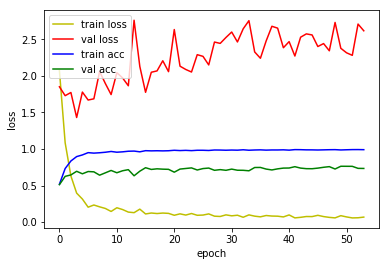

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.5778 - acc: 0.6600
Loss: 1.5777674066438605 Accuracy: 0.66002077

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5691 - acc: 0.5644
Epoch 00001: val_loss improved from inf to 1.35284, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_6_conv_checkpoint/001-1.3528.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.5690 - acc: 0.5644 - val_loss: 1.3528 - val_acc: 0.5998
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8452 - acc: 0.7644
Epoch 00002: val_loss improved from 1.35284 to 1.01697, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_6_conv_checkpoint/002-1.0170.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.8452 - acc: 0.7644 - val_loss: 1.0170 - val_acc: 0.7310
Epoch 3/500
36800/36805 [=====================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9839
Epoch 00028: val_loss did not improve from 0.59668
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0607 - acc: 0.9839 - val_loss: 0.8036 - val_acc: 0.8710
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9898
Epoch 00029: val_loss did not improve from 0.59668
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0403 - acc: 0.9898 - val_loss: 0.8319 - val_acc: 0.8623
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9926
Epoch 00030: val_loss did not improve from 0.59668
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0302 - acc: 0.9926 - val_loss: 0.6779 - val_acc: 0.8793
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9912
Epoch 00031: val_loss did not improve from 0.59668
36805/36805 [========

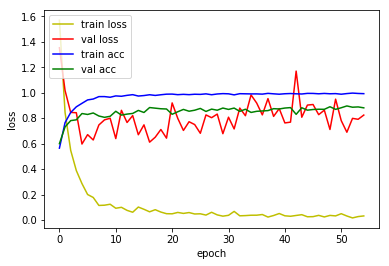

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.7025 - acc: 0.8114
Loss: 0.7024740458525106 Accuracy: 0.81142265

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3045 - acc: 0.6126
Epoch 00001: val_loss improved from inf to 1.21019, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_7_conv_checkpoint/001-1.2102.hdf5
36805/36805 [==============================] - 122s 3ms/sample - loss: 1.3045 - acc: 0.6125 - val_loss: 1.2102 - val_acc: 0.6003
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5999 - acc: 0.8269
Epoch 00002: val_loss improved from 1.21019 to 0.52355, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_7_conv_checkpoint/002-0.5236.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.6000 - acc: 0.8269 - val_loss: 0.5236 - val_acc: 0.8449
Epoch 3/500
36800/36805 [=====================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9864
Epoch 00027: val_loss did not improve from 0.30061
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0438 - acc: 0.9864 - val_loss: 0.4116 - val_acc: 0.9140
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9949
Epoch 00028: val_loss did not improve from 0.30061
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0183 - acc: 0.9949 - val_loss: 0.3150 - val_acc: 0.9369
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9957
Epoch 00029: val_loss did not improve from 0.30061
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0169 - acc: 0.9957 - val_loss: 0.3098 - val_acc: 0.9357
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9868
Epoch 00030: val_loss did not improve from 0.30061
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9916
Epoch 00056: val_loss did not improve from 0.27744
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0341 - acc: 0.9916 - val_loss: 0.3670 - val_acc: 0.9331
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.27744
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0199 - acc: 0.9951 - val_loss: 0.3237 - val_acc: 0.9436
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9974
Epoch 00058: val_loss did not improve from 0.27744
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0096 - acc: 0.9974 - val_loss: 0.3590 - val_acc: 0.9455
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.27744
36805/36805 [=====================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9976
Epoch 00086: val_loss did not improve from 0.27744
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0079 - acc: 0.9976 - val_loss: 0.3862 - val_acc: 0.9446
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9978
Epoch 00087: val_loss did not improve from 0.27744
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0078 - acc: 0.9978 - val_loss: 0.3488 - val_acc: 0.9492
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9979
Epoch 00088: val_loss did not improve from 0.27744
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0075 - acc: 0.9979 - val_loss: 0.3881 - val_acc: 0.9371
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9939
Epoch 00089: val_loss did not improve from 0.27744
36805/36805 [========

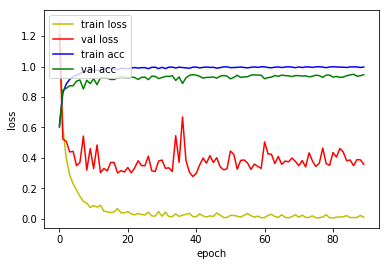

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3865 - acc: 0.9244
Loss: 0.386487360042544 Accuracy: 0.9244029

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0631 - acc: 0.6811
Epoch 00001: val_loss improved from inf to 0.77607, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_8_conv_checkpoint/001-0.7761.hdf5
36805/36805 [==============================] - 125s 3ms/sample - loss: 1.0632 - acc: 0.6811 - val_loss: 0.7761 - val_acc: 0.7661
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4232 - acc: 0.8720
Epoch 00002: val_loss improved from 0.77607 to 0.35306, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_8_conv_checkpoint/002-0.3531.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.4232 - acc: 0.8719 - val_loss: 0.3531 - val_acc: 0.8963
Epoch 3/500
36800/36805 [=======================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9974
Epoch 00027: val_loss did not improve from 0.16218
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0106 - acc: 0.9974 - val_loss: 0.1820 - val_acc: 0.9576
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9916
Epoch 00028: val_loss did not improve from 0.16218
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0271 - acc: 0.9916 - val_loss: 0.1738 - val_acc: 0.9541
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9981
Epoch 00029: val_loss improved from 0.16218 to 0.15576, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_BN_8_conv_checkpoint/029-0.1558.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0078 - acc: 0.9981 - val_loss: 0.1558 - val_acc: 0.9571
Epoch 30/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9994
Epoch 00056: val_loss did not improve from 0.15576
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0026 - acc: 0.9994 - val_loss: 0.1644 - val_acc: 0.9627
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9990
Epoch 00057: val_loss did not improve from 0.15576
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0037 - acc: 0.9990 - val_loss: 0.1755 - val_acc: 0.9625
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9961
Epoch 00058: val_loss did not improve from 0.15576
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0117 - acc: 0.9961 - val_loss: 0.2363 - val_acc: 0.9492
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9973
Epoch 00059: val_loss did not improve from 0.15576
36805/36805 [=====================

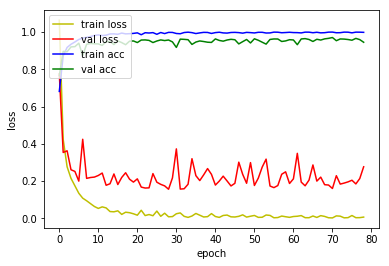

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2443 - acc: 0.9452
Loss: 0.24427985519070183 Accuracy: 0.94517136



In [10]:
base = '1D_CNN_custom_multi_3_concat_ch_128_BN'

for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_ch_128_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.5778 - acc: 0.6600
Loss: 1.5777674066438605 Accuracy: 0.66002077

1D_CNN_custom_multi_3_concat_ch_128_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_50 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3865 - acc: 0.9244
Loss: 0.386487360042544 Accuracy: 0.9244029

1D_CNN_custom_multi_3_concat_ch_128_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_65 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activati

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2443 - acc: 0.9452
Loss: 0.24427985519070183 Accuracy: 0.94517136


In [12]:
for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_concat_ch_128_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 3.1752 - acc: 0.6908
Loss: 3.1751595623891795 Accuracy: 0.69075805

1D_CNN_custom_multi_3_concat_ch_128_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_50 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activa

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.4468 - acc: 0.9292
Loss: 0.446770729758387 Accuracy: 0.92917967

1D_CNN_custom_multi_3_concat_ch_128_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_65 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activat

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4039 - acc: 0.9275
Loss: 0.40390394258768386 Accuracy: 0.9275182
